In [ ]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "/content/drive/MyDrive/Colab_Notebooks/balanced_dataset_final.csv"

df = dk.read_csv(file_path)

label
6    2634124
4    4999999
5    4999999
0    1098195
Name: count, dtype: int64


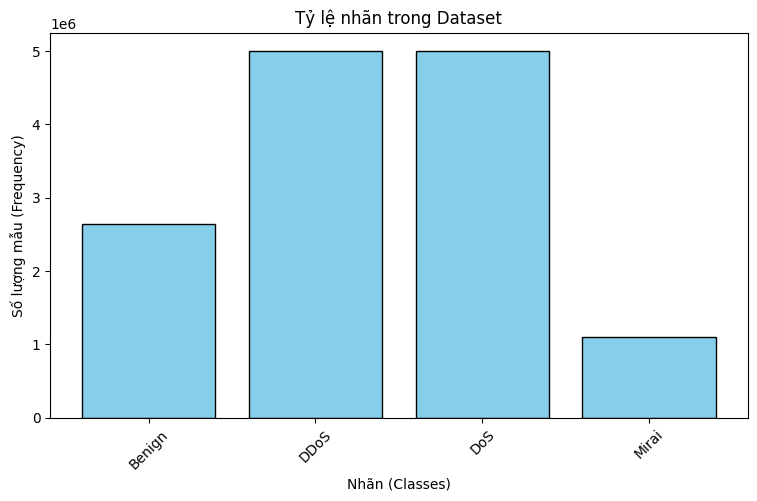

In [ ]:
import matplotlib.pyplot as plt

# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood',
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()
print(label_counts)
labels = ["Benign","DDoS","DoS","Mirai"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [ ]:
import dask.dataframe as dk
import pandas as pd
from dask.diagnostics import ProgressBar
import os
import time
import shutil

def process_large_dataset(input_csv, output_csv, target_ddos=2000000, chunk_size=200000):

    print("Bắt đầu xử lý dataset cực lớn...")
    start_time = time.time()

    # Tạo thư mục tạm với timestamp để tránh trùng lặp
    temp_dir = f"temp_chunks_{int(time.time())}"
    os.makedirs(temp_dir, exist_ok=True)

    try:
        # 1. Đếm tổng số mẫu DDoS
        print("Đang đếm tổng số mẫu DDoS...")
        ddf = dk.read_csv(input_csv)
        total_ddos = ddf[ddf['label'] == 4].shape[0].compute()
        print(f"Tổng số mẫu DDoS: {total_ddos:,}")

        # 2. Tính toán tỷ lệ lấy mẫu
        sample_frac_ddos = target_ddos / total_ddos
        print(f"Tỷ lệ lấy mẫu DDos: {sample_frac_ddos:.4f}")

        print("Đang đếm tổng số mẫu DoS...")
        total_dos = ddf[ddf['label'] == 5].shape[0].compute()
        print(f"Tổng số mẫu DoS: {total_dos:,}")

        # 2. Tính toán tỷ lệ lấy mẫu
        sample_frac_dos = target_ddos / total_dos
        print(f"Tỷ lệ lấy mẫu: {sample_frac_dos:.4f}")
        # 3. Xử lý từng chunk
        print("Bắt đầu xử lý từng chunk...")
        reader = pd.read_csv(input_csv, chunksize=chunk_size)

        sampled_ddos = []
        sampled_dos =[]
        processed_chunks = 0
        first_benign_chunk = True
        first_mirai_chunk = True
        for chunk in reader:
            # Lọc và lấy mẫu DDoS
            ddos_chunk = chunk[chunk['label'] == 4]
            if not ddos_chunk.empty:
                sampled = ddos_chunk.sample(frac=sample_frac_ddos, random_state=42)
                sampled_ddos.append(sampled)

            dos_chunk = chunk[chunk['label'] == 5]
            if not dos_chunk.empty:
                sampled = dos_chunk.sample(frac=sample_frac_dos, random_state=42)
                sampled_dos.append(sampled)
            # Ghi Benign chunks
            benign_chunk = chunk[chunk['label'] == 0]
            if not benign_chunk.empty:
                benign_path = os.path.join(temp_dir, "benign.csv")
                benign_chunk.to_csv(
                    benign_path,
                    index=False,
                    mode='a',
                    header=first_benign_chunk
                )
                first_benign_chunk = False
            # Ghi mirai chunks
            mirai_chunk = chunk[chunk['label'] == 6]
            if not mirai_chunk.empty:
                mirai_path = os.path.join(temp_dir, "mirai.csv")
                mirai_chunk.to_csv(
                    mirai_path,
                    index=False,
                    mode='a',
                    header=first_mirai_chunk
                )
                first_mirai_chunk = False
            processed_chunks += 1
            if processed_chunks % 10 == 0:
                print(f"Đã xử lý {processed_chunks} chunks...")

        # 4. Ghi mẫu DDoS đã lấy
        if sampled_ddos:
            final_ddos = pd.concat(sampled_ddos)
            final_ddos.to_csv(
                os.path.join(temp_dir, "ddos_samples.csv"),
                index=False
            )
        if sampled_dos:
            final_dos = pd.concat(sampled_dos)
            final_dos.to_csv(
                os.path.join(temp_dir, "dos_samples.csv"),
                index=False
            )
        # 5. Kết hợp các file tạm
        print("Đang hợp nhất các file tạm...")

        # Đọc lại bằng Dask
        ddos_path = os.path.join(temp_dir, "ddos_samples.csv")
        dos_path = os.path.join(temp_dir, "dos_samples.csv")
        benign_path = os.path.join(temp_dir, "benign.csv")
        mirai_path = os.path.join(temp_dir, "mirai.csv")
        if os.path.exists(ddos_path) and os.path.exists(benign_path) and os.path.exists(mirai_path) and os.path.exists(dos_path):
            balanced = dk.concat([
                dk.read_csv(ddos_path),
                dk.read_csv(dos_path),
                dk.read_csv(mirai_path),
                dk.read_csv(benign_path)
            ])
        elif os.path.exists(ddos_path):
            balanced = dk.read_csv(ddos_path)
        elif os.path.exists(dos_path):
            balanced = dk.read_csv(dos_path)
        else:
            balanced = dk.read_csv(benign_path)

        # 6. Ghi file kết quả
        with ProgressBar():
            balanced.to_csv(
                output_csv,
                index=False,
                single_file=True
            )

        # 7. Thống kê
        final_count = balanced.shape[0].compute()
        final_ddos_count = balanced[balanced['label'] == 4].shape[0].compute() if os.path.exists(ddos_path) else 0
        final_dos_count = balanced[balanced['label'] == 5].shape[0].compute() if os.path.exists(dos_path) else 0
        final_mirai_count = balanced[balanced['label'] == 6].shape[0].compute() if os.path.exists(mirai_path) else 0
        print("\n" + "="*50)
        print(f"HOÀN THÀNH! File đã được lưu tại: {output_csv}")
        print(f"Tổng số mẫu: {final_count:,}")
        print(f"- Mẫu DDoS: {final_ddos_count:,} ({(final_ddos_count/final_count)*100:.1f}%)")
        print(f"- Mẫu DoS: {final_dos_count:,} ({(final_dos_count/final_count)*100:.1f}%)")
        print(f"- Mẫu Mirai: {final_mirai_count:,} ({(final_mirai_count/final_count)*100:.1f}%)")
        print(f"Thời gian xử lý: {(time.time()-start_time)/60:.2f} phút")
        print("="*50)

    finally:
        # Dọn dẹp thư mục tạm
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)

if __name__ == "__main__":
    process_large_dataset(
        input_csv='/content/drive/MyDrive/Colab_Notebooks/Mapped_Dataset.csv',
        output_csv='/content/drive/MyDrive/Colab_Notebooks/balanced_dataset_final.csv',
        target_ddos=5000000,
        chunk_size=500000
    )

Bắt đầu xử lý dataset cực lớn...
Đang đếm tổng số mẫu DDoS...
Tổng số mẫu DDoS: 33,984,560
Tỷ lệ lấy mẫu DDos: 0.1471
Đang đếm tổng số mẫu DoS...
Tổng số mẫu DoS: 8,090,738
Tỷ lệ lấy mẫu: 0.6180
Bắt đầu xử lý từng chunk...
Đã xử lý 10 chunks...
Đã xử lý 20 chunks...
Đã xử lý 30 chunks...
Đã xử lý 40 chunks...
Đã xử lý 50 chunks...
Đã xử lý 60 chunks...
Đã xử lý 70 chunks...
Đã xử lý 80 chunks...
Đã xử lý 90 chunks...
Đang hợp nhất các file tạm...
[########################################] | 100% Completed | 11m 14s

HOÀN THÀNH! File đã được lưu tại: /content/drive/MyDrive/Colab_Notebooks/balanced_dataset_final.csv
Tổng số mẫu: 13,732,317
- Mẫu DDoS: 4,999,999 (36.4%)
- Mẫu DoS: 4,999,999 (36.4%)
- Mẫu Mirai: 2,634,124 (19.2%)
Thời gian xử lý: 40.08 phút
